In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# import tensorflow as tf
import functools
import jax.numpy as jnp
import os
import json
import numpy as np

import jax
from jax.experimental import optimizers
from src import data, model_utils
from renn.rnn import cells, unroll, network
from renn import utils
import renn

from data_processing import analysis_utils as au
from renn import analysis_utils as renn_au

import tensorflow_datasets as tfds

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Model and data loading

In [4]:
data_folder = 'results/ag_news/5_Epoch/classes_3_cell_LSTM_eta_0.01_L2_0.1_run_h8xnvqb9/'

In [5]:
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)

In [6]:
with open(os.path.join(data_folder, 'test_acc.jsonl')) as f:
    x = f.readlines()
x[-1]

'{"step": "7030", "value": 0.9497893258426966}\n'

### Get data

In [7]:
vocab_size, train_dset, test_dset = data.get_dataset(config['data'])

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [8]:
config['data']

{'dataset': 'ag_news', 'batch_size': 64, 'max_pad': 160, 'num_classes': 3}

### Get model

In [9]:
cell = model_utils.get_cell(config['model']['cell_type'],
                            num_units=config['model']['num_units'])

In [10]:
init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(vocab_size, 
                                     config['model']['emb_size'])

In [11]:
network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

In [12]:
optimizers.l2_norm(rnn_params)

DeviceArray(1.5458583, dtype=float32)

## Analysis

### PCA of hidden states

In [13]:
test_batch = next(iter(tfds.as_numpy(test_dset)))

In [14]:
visited_states = {'original': au.rnn_states(cell, test_batch, rnn_params, emb_params, emb_apply)}
final_states = {'original': au.rnn_end_states(cell, test_batch, rnn_params, emb_params, emb_apply)}

In [15]:
PCA_objects = {'visited': au.PCA_rnn(),
               'final': au.PCA_rnn(),
               'fixed': au.PCA_rnn()}

PCA_objects['visited'].fit(np.vstack(visited_states['original']))
PCA_objects['final'].fit(np.vstack(final_states['original']))

PCA_rnn()

In [16]:
visited_states['transformed'] = [PCA_objects['visited'].transform(v) for v in visited_states['original']]
final_states['transformed'] = [PCA_objects['visited'].transform(f) for f in final_states['original']]

In [17]:
dimensionalities = {'visited': au.cumulative_var_explained(PCA_objects['visited']),
                    'final': au.cumulative_var_explained(PCA_objects['final'])}

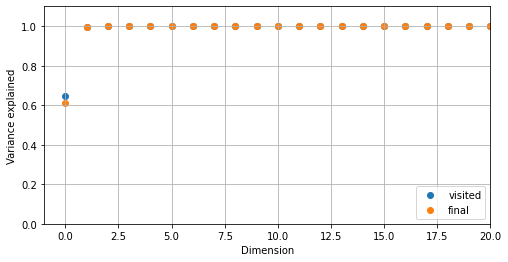

In [18]:
f = au.plot_varexp(dimensionalities)

In [19]:
coordinates = ['original', 'transformed']

visited_by_value = {c: au.states_by_value(visited_states[c], test_batch['labels'], config['data']['num_classes']) for c in coordinates}
final_by_value = {c: au.states_by_value(final_states[c], test_batch['labels'], config['data']['num_classes']) for c in coordinates}

### Visualizing trajectories in 2D PCA plane

In [20]:
initial_state_vector = {'original': cell.get_initial_state(rnn_params, batch_size=1)}
initial_state_vector['transformed'] = PCA_objects['visited'].transform(initial_state_vector['original'])

In [21]:
readout_vectors = {'original': readout_params[0].T}
readout_vectors['transformed'] = PCA_objects['visited'].transform_no_mean(readout_vectors['original'])

TypeError: cannot unpack non-iterable NoneType object

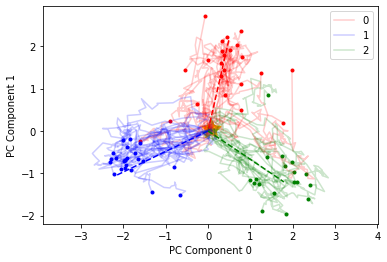

In [22]:
fig, ax = au.plot_states(visited_by_value['transformed'], 
            readout_vectors['transformed'], 
            initial_state_vector['transformed'], 
            pc_dimensions=[0,1])

(0.0, 60.0)

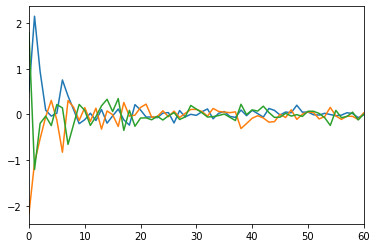

In [23]:
plt.plot(readout_vectors['transformed'].T)
plt.xlim(0,60)

In [24]:
plt.figure(figsize=(10,10))

def plot_traj(ang1, ang2):
    fig, ax = au.plot_states(visited_by_value['transformed'], 
                readout_vectors['transformed'], 
                initial_state_vector['transformed'], 
                pc_dimensions=[0,1, 2])

    ax.view_init(ang1, ang2)    
    
interact(plot_traj, ang1=widgets.FloatSlider(value=0, min=0, max=180, step=3),
                    ang2=widgets.FloatSlider(value=0, min=0, max=180, step=3))

<Figure size 720x720 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='ang1', max=180.0, step=3.0), FloatSlider(value=0.0, …

<function __main__.plot_traj(ang1, ang2)>

### Dot-products between readout vectors

In [25]:
normalized_readouts = [a/np.linalg.norm(a) for a in readout_vectors['transformed']]
readout_dots = np.array([[np.dot(a,b) for a in normalized_readouts] for b in normalized_readouts])

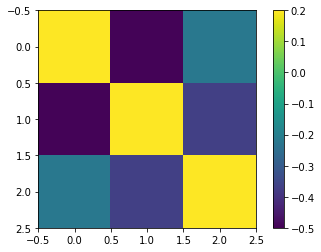

In [26]:
plt.imshow(readout_dots, vmin=-0.5, vmax=0.2) 
plt.colorbar()

In [27]:
np.round(readout_dots, 3)

array([[ 1.   , -0.493, -0.22 ],
       [-0.493,  1.   , -0.367],
       [-0.22 , -0.367,  1.   ]], dtype=float32)

### Find the fixed points

In [28]:
fixed_points_, loss_hist, fp_losses = au.fixed_points(cell,
                                                    rnn_params,
                                                    visited_states['original'],
                                                    tolerance=35e-6,
                                                    embedding_size=config['model']['emb_size'],
                                                    noise_scale=.5,
                                                    decimation_factor=4
                                                    )

fixed_points = {'original': fixed_points_,
                'transformed': PCA_objects['visited'].transform(fixed_points_)}

Text(0, 0.5, 'Fixed point loss')

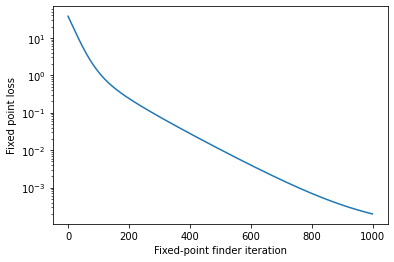

In [29]:
plt.semilogy(loss_hist)
plt.xlabel('Fixed-point finder iteration')
plt.ylabel('Fixed point loss')

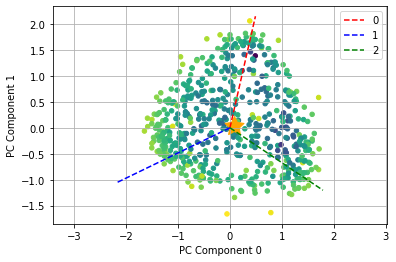

In [30]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])

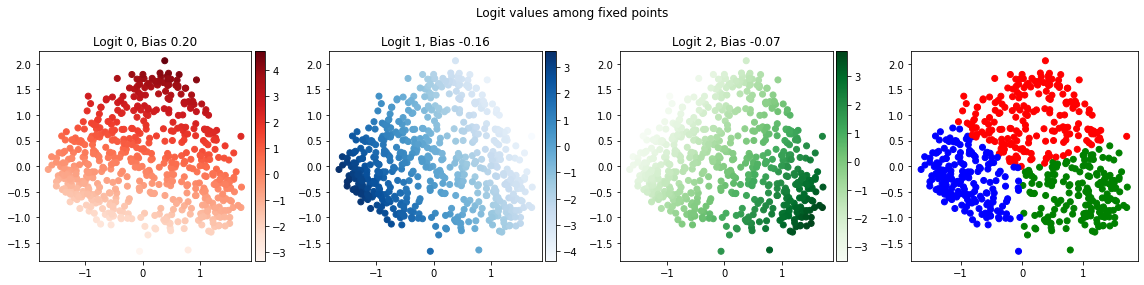

In [31]:
au.plot_logits(readout_apply, readout_params, fixed_points['original'], PCA_objects['visited']);

In the above plots, we calculate the logit by directly running the readout function.  As a sanity check, and a check that our lower-dimensional representation is capturing well-enough the relevant details, we can also calculate the logits by dot-producting the projected readout vector and the projected point.

#### Dimensionality of the fixed point manifold

In [32]:
PCA_objects['fixed'].fit(fixed_points['original'])
dimensionalities['fixed']= au.cumulative_var_explained(PCA_objects['fixed'])

(-1.0, 8.0)

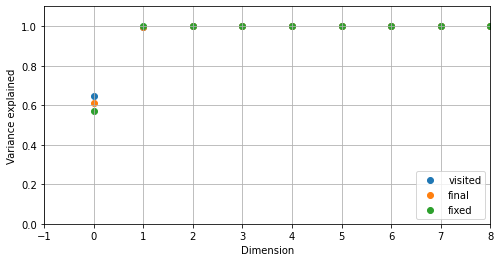

In [33]:
f = au.plot_varexp(dimensionalities)
plt.xlim(-1, 8)

### Interpolating the fixed-point manifold

In [50]:
x_lim = 3
y_lim = 3

density = 100 

In [51]:
dimension = PCA_objects['fixed'].n_components_
coordinates = {0: np.linspace(-x_lim, x_lim, density),
               1: np.linspace(-y_lim, y_lim, density),}

pca_plane = renn_au.pseudogrid(coordinates, dimension)

In [52]:
pca_transformed = PCA_objects['fixed'].inverse_transform(pca_plane)

In [53]:
fp_loss_fn = renn.build_fixed_point_loss(cell, rnn_params)

In [54]:
input_lin = jnp.zeros((pca_transformed.shape[0], config['model']['emb_size']))
fp_l = fp_loss_fn(pca_transformed, input_lin)

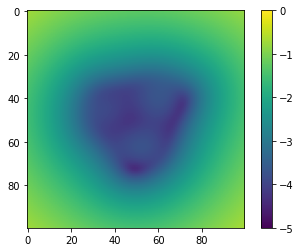

In [55]:
plt.imshow(np.log10(fp_l).reshape(density, density), cmap='viridis', vmin=-5, vmax=0)

plt.colorbar()

In [151]:
np.min(np.log10(fp_l))

-5.0062995

Text(0.5, 0, 'PC 1 Coordinate')

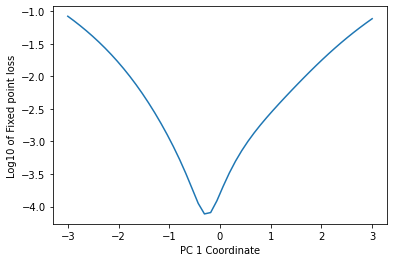

In [152]:
plt.plot(y_coords, np.log10(fp_l)[35::density])
plt.ylabel('Log10 of Fixed point loss')
plt.xlabel('PC 1 Coordinate')

### Check alignment of the fixed point PCA vectors with the hidden state PCA vectors

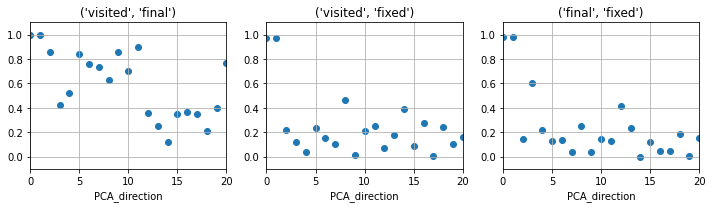

In [52]:
f = au.plot_alignment(PCA_objects)

### Fixed-point selector and Recurrent Jacobian

In [53]:
fixed_point_index = 140

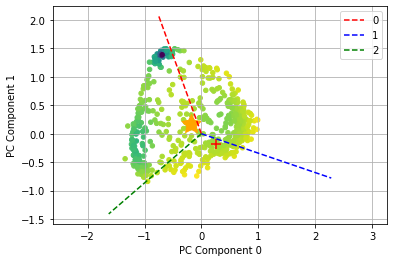

In [54]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1],
              point_to_highlight=fixed_point_index)

In [55]:
J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fixed_points['original'][fixed_point_index])

R, E, L = renn.eigsorted(J_hh)

Text(0, 0.5, 'imag')

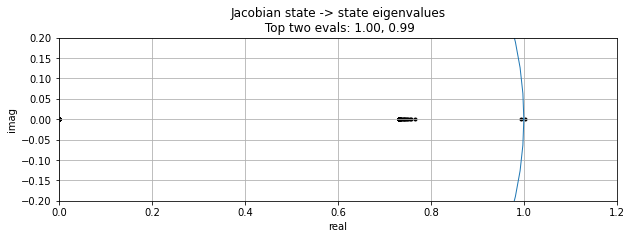

In [56]:
plt.figure(figsize=(10, 3))
plt.grid()
plt.scatter(np.real(E), np.imag(E), c='k', marker='.')
plt.xlim(0., 1.2)
plt.ylim(-0.2, 0.2)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.title(f'Jacobian state -> state eigenvalues\n Top two evals: {np.real(E[0]):0.2f}, {np.real(E[1]):0.2f}')
plt.xlabel('real')
plt.ylabel('imag')

### Alignment of the integration eigenmodes with the fixed-point plane

In [57]:
def in_plane_magnitudes(eigenvectors, PCA_obj, dimensions_to_keep=2):
    """
    eigenvectors is shape (n_points, evec_dimension, n_eigenvects)
    
    """
        
    mags = []
    
    for i in range(len(eigenvectors)):
        full_norms = np.linalg.norm(eigenvectors[i,:,:],axis=0)
        transformed = PCA_obj.transform_no_mean(np.real(eigenvectors[i,:,:].T))[:,:dimensions_to_keep]
        plane_norms = np.linalg.norm(transformed,axis=1)
        
        mags.append(plane_norms/full_norms)
    return np.array(mags)

In [58]:
n_integration_modes = 2

In [59]:
J_fn = lambda p : cell.rec_jac(rnn_params, jnp.zeros(config['model']['emb_size']), p)
top_evecs = au.top_evecs(J_fn, fixed_points['original'][::10], top_k = n_integration_modes)

In [60]:
ipm = in_plane_magnitudes(top_evecs, PCA_objects['fixed'], dimensions_to_keep=n_integration_modes)

Text(0, 0.5, 'Frequency')

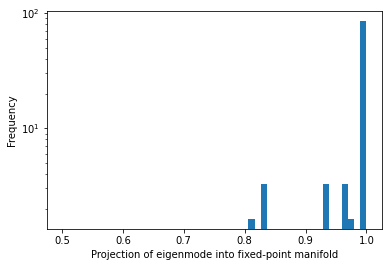

In [61]:
plt.hist(ipm.flatten(), bins=np.linspace(00.5,1,50), density=True, log=True);
plt.xlabel('Projection of eigenmode into fixed-point manifold')
plt.ylabel('Frequency')

### Individual word analysis

In [62]:
initial_pts = fixed_points['original'][::3]
l = fp_losses[::3]

In [63]:
initial_pts.shape

(198, 512)

In [64]:
with open('./data/vocab/ag_news.vocab', 'r') as f:
    vocab = f.readlines()

In [65]:
vocab

['<unk>\n',
 '<cls>\n',
 '<sep>\n',
 '!\n',
 '"\n',
 '#\n',
 '$\n',
 '&\n',
 "'\n",
 '(\n',
 ')\n',
 '*\n',
 ',\n',
 '-\n',
 '.\n',
 '/\n',
 '0\n',
 '1\n',
 '2\n',
 '3\n',
 '4\n',
 '5\n',
 '6\n',
 '7\n',
 '8\n',
 '9\n',
 ':\n',
 ';\n',
 '=\n',
 '?\n',
 '\\\n',
 '_\n',
 'a\n',
 'b\n',
 'c\n',
 'd\n',
 'e\n',
 'f\n',
 'g\n',
 'h\n',
 'i\n',
 'j\n',
 'k\n',
 'l\n',
 'm\n',
 'n\n',
 'o\n',
 'p\n',
 'q\n',
 'r\n',
 's\n',
 't\n',
 'u\n',
 'v\n',
 'w\n',
 'x\n',
 'y\n',
 'z\n',
 'the\n',
 'to\n',
 'of\n',
 'in\n',
 'and\n',
 'on\n',
 'for\n',
 'that\n',
 '##,\n',
 '#39;s\n',
 '##.\n',
 'with\n',
 'as\n',
 'its\n',
 'at\n',
 'is\n',
 'by\n',
 'has\n',
 'it\n',
 'new\n',
 'said\n',
 'an\n',
 'from\n',
 'his\n',
 'will\n',
 'was\n',
 'after\n',
 'have\n',
 'be\n',
 'their\n',
 '##s\n',
 'are\n',
 'over\n',
 '(reuters)\n',
 'he\n',
 'but\n',
 'us\n',
 'two\n',
 'first\n',
 'ap\n',
 '--\n',
 'this\n',
 'more\n',
 'up\n',
 'one\n',
 'they\n',
 'last\n',
 'against\n',
 'than\n',
 'about\n',
 'who\n

In [66]:
word = 'football'
inp_num = vocab.index(f'{word}\n')
print(inp_num)

387


In [67]:
word_input_ = emb_apply(emb_params, [inp_num])
word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)

In [68]:
transformed = PCA_objects['visited'].transform(initial_pts).T

In [69]:
final_pts = cell.batch_apply(rnn_params, word_input, initial_pts)
transformed_final = PCA_objects['visited'].transform(final_pts).T

In [74]:
dirs = []
for i, p in enumerate(initial_pts):
    J_xh = cell.inp_jac(rnn_params, 
                        jnp.zeros(config['model']['emb_size']), 
                        p)
    jacobian_direction = PCA_objects['visited'].transform_no_mean(jnp.dot(J_xh, word_input_.T).T)
#     jacobian_direction = PCA_objects['visited'].transform(jnp.dot(J_xh, word_input_.T).T)
    dirs.append(jacobian_direction[0])
dirs = np.array(dirs)

Text(0, 0.5, 'PC 1 component')

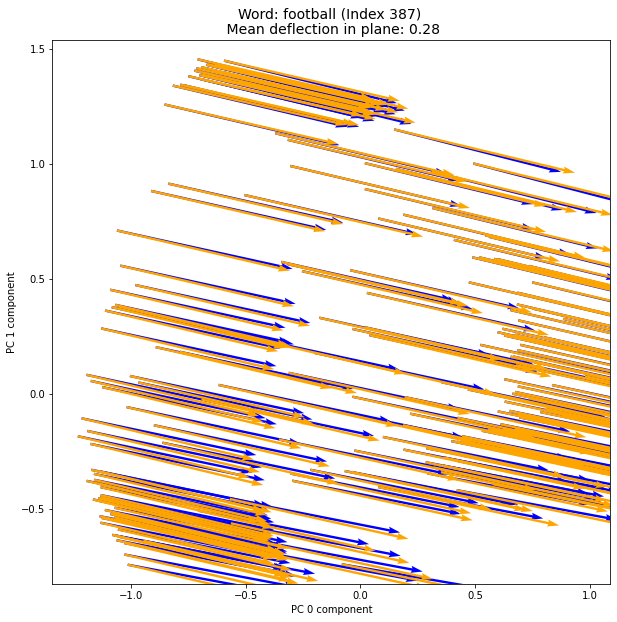

In [75]:
initial_states = [transformed[0], transformed[1]]
final_states = np.array([transformed_final[0], transformed_final[1]])

deltas = final_states - np.array(initial_states)

plt.figure(figsize=(10,10))
plt.quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=1, units='xy', color='blue')
plt.quiver(initial_states[0], initial_states[1], dirs[:,0], dirs[:,1], scale=1, units='xy', color='orange')
plt.axis('equal')

s = np.mean(deltas**2)

plt.title(f'Word: {word} (Index {inp_num}) \n Mean deflection in plane: {s:0.2f}', fontsize=14)
plt.xlabel('PC 0 component')
plt.ylabel('PC 1 component')

# plt.scatter(initial_states[0], initial_states[1], c = np.log10(l), marker='.')



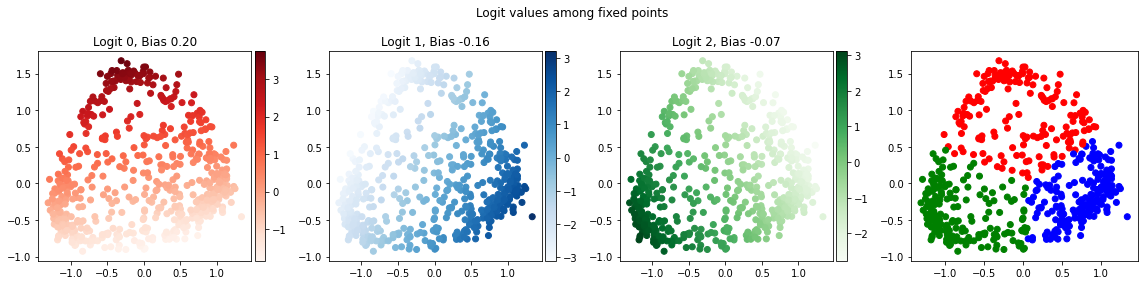

In [82]:
au.plot_logits(readout_apply, readout_params, fixed_points['original'], PCA_objects['visited']);

# Histogramming lengths of the AG News dataset

In [85]:
from collections import Counter

In [97]:
c = Counter()

In [98]:
for batch in tfds.as_numpy(train_dset):
    c.update(batch['index'])

In [99]:
c

Counter({27: 3453,
         37: 3842,
         24: 2473,
         23: 2031,
         30: 3968,
         32: 4050,
         34: 4056,
         36: 3922,
         28: 3742,
         19: 827,
         40: 2868,
         26: 3259,
         38: 3577,
         90: 81,
         35: 4049,
         33: 4182,
         29: 3852,
         48: 766,
         42: 2222,
         22: 1698,
         47: 929,
         39: 3177,
         51: 413,
         31: 4029,
         43: 1872,
         21: 1301,
         44: 1574,
         41: 2539,
         77: 62,
         15: 320,
         45: 1343,
         20: 1021,
         25: 2906,
         58: 122,
         64: 124,
         111: 6,
         18: 706,
         46: 1135,
         59: 133,
         49: 567,
         82: 46,
         17: 584,
         73: 69,
         151: 6,
         88: 55,
         100: 49,
         94: 107,
         55: 202,
         52: 344,
         96: 70,
         69: 102,
         56: 205,
         54: 237,
         53: 294,
         

In [102]:
l = [li[0] for li in sorted(c.items())]
co = [li[1] for li in sorted(c.items())]

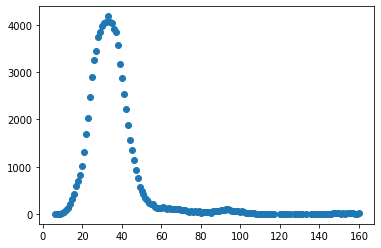

In [103]:
plt.scatter(l, co)

In [100]:
plt.plot()

Counter({27: 3453,
         37: 3842,
         24: 2473,
         23: 2031,
         30: 3968,
         32: 4050,
         34: 4056,
         36: 3922,
         28: 3742,
         19: 827,
         40: 2868,
         26: 3259,
         38: 3577,
         90: 81,
         35: 4049,
         33: 4182,
         29: 3852,
         48: 766,
         42: 2222,
         22: 1698,
         47: 929,
         39: 3177,
         51: 413,
         31: 4029,
         43: 1872,
         21: 1301,
         44: 1574,
         41: 2539,
         77: 62,
         15: 320,
         45: 1343,
         20: 1021,
         25: 2906,
         58: 122,
         64: 124,
         111: 6,
         18: 706,
         46: 1135,
         59: 133,
         49: 567,
         82: 46,
         17: 584,
         73: 69,
         151: 6,
         88: 55,
         100: 49,
         94: 107,
         55: 202,
         52: 344,
         96: 70,
         69: 102,
         56: 205,
         54: 237,
         53: 294,
         

## Scratch

In [77]:
BASIC_WORDS = {'very': 2,
               'some': 1,
               'neutral': 0,
               'not': -1}

classes = range(5)

In [78]:
from itertools import product

In [80]:
list(product(BASIC_WORDS, classes))

[('very', 0),
 ('very', 1),
 ('very', 2),
 ('very', 3),
 ('very', 4),
 ('some', 0),
 ('some', 1),
 ('some', 2),
 ('some', 3),
 ('some', 4),
 ('neutral', 0),
 ('neutral', 1),
 ('neutral', 2),
 ('neutral', 3),
 ('neutral', 4),
 ('not', 0),
 ('not', 1),
 ('not', 2),
 ('not', 3),
 ('not', 4)]

In [81]:
np.zeros(4)

array([0., 0., 0., 0.])

In [83]:
np.empty(4).fill(30)

In [85]:
x = product([0,1],[0,3])

In [86]:
for i, w in enumerate(x):
    print(i)
    print(w)

0
(0, 0)
1
(0, 3)
2
(1, 0)
3
(1, 3)


In [87]:
and(True, False)

SyntaxError: invalid syntax (<ipython-input-87-ed671c679e6d>, line 1)

In [88]:

np.random.randint(2,4,(5,))

array([2, 3, 2, 2, 3])